In [1]:
import warnings
warnings.filterwarnings('ignore')

import random
import os
import numpy as np
import mxnet as mx
from mxnet import gluon, nd, autograd
import gluonnlp as nlp
from bert import *
from gluonnlp.data import TSVDataset

from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from glob import glob

np.random.seed(100)
random.seed(100)
mx.random.seed(10000)
ctx = mx.gpu(0) if mx.test_utils.list_gpus() else mx.cpu()

In [2]:
#ROOT_DIR = '/home/yaserkl/data/imdb/v1/'
ROOT_DIR = '/home/yaserkl/working_dir/classification/20ng/tflean_200_200_w2v/'
working_dir = "/home/yaserkl/working_dir/classification/gluon/bert/20ng/"
if not os.path.exists(working_dir):
    os.makedirs(working_dir)
filename = '{}/net.params'.format(working_dir)

In [3]:
# network params
# maximum sequence length
max_len = 150
n_classes = 20
all_labels = [str(_) for _ in range(n_classes)]
batch_size = 32
lr = 5e-6
grad_clip = 1
log_interval = 4
num_epochs = 10
max_patience = 5

In [4]:
def print_results(y_true, y_pred):
    print(f1_score(y_true, y_pred, average="macro"))
    print(precision_score(y_true, y_pred, average="macro"))
    print(recall_score(y_true, y_pred, average="macro"))
    fig, ax = plt.subplots(figsize=(19, 10))
    x = sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, ax=ax)
    x.invert_yaxis()
    plt.xlabel("Predicted")
    plt.ylabel("True")
    return fig

class Dataset(TSVDataset):
    """Train dataset.

    Parameters
    ----------
    segment : str or list of str, default 'train'
        Dataset segment. Options are 'train', 'val', 'test' or their combinations.
    root : str, default 'dir containing train/dev/test datasets'
    """
    def __init__(self, segment='train', root=ROOT_DIR, n_classes=2):
        self._supported_segments = ['train', 'dev', 'test']
        assert segment in self._supported_segments, 'Unsupported segment: %s'%segment
        path = os.path.join(root, '%s.tsv'%segment)
        A_IDX, LABEL_IDX = 0, 1
        fields = [A_IDX, LABEL_IDX]
        self.n_classes=n_classes
        super(Dataset, self).__init__(path, field_indices=fields)

    @staticmethod
    def get_labels():
        """Get classification label ids of the dataset."""
        return [str(_) for _ in range(self.n_classes)]

In [5]:
bert_base, vocabulary = nlp.model.get_model('bert_12_768_12',
                                             dataset_name='book_corpus_wiki_en_uncased',
                                             pretrained=True, ctx=ctx, use_pooler=True,
                                             use_decoder=False, use_classifier=False)
print(bert_base)

BERTModel(
  (encoder): BERTEncoder(
    (dropout_layer): Dropout(p = 0.1, axes=())
    (layer_norm): BERTLayerNorm(in_channels=768, epsilon=1e-12)
    (transformer_cells): HybridSequential(
      (0): BERTEncoderCell(
        (dropout_layer): Dropout(p = 0.1, axes=())
        (attention_cell): MultiHeadAttentionCell(
          (_base_cell): DotProductAttentionCell(
            (_dropout_layer): Dropout(p = 0.1, axes=())
          )
          (proj_query): Dense(768 -> 768, linear)
          (proj_key): Dense(768 -> 768, linear)
          (proj_value): Dense(768 -> 768, linear)
        )
        (proj): Dense(768 -> 768, linear)
        (ffn): BERTPositionwiseFFN(
          (ffn_1): Dense(768 -> 3072, linear)
          (activation): GELU()
          (ffn_2): Dense(3072 -> 768, linear)
          (dropout_layer): Dropout(p = 0.1, axes=())
          (layer_norm): BERTLayerNorm(in_channels=768, epsilon=1e-12)
        )
        (layer_norm): BERTLayerNorm(in_channels=768, epsilon=1e-12)
   

In [6]:
data_train = Dataset('train', n_classes=n_classes)
data_dev = Dataset('dev', n_classes=n_classes)
data_test = Dataset('test', n_classes=n_classes)

In [7]:
sample_id = 0
# sentence a
print(data_train[sample_id][0])
# label
print(data_train[sample_id][1])

from randy msc cornell edu \\( randy ellingson \\) subject re canon bj200 \\( bubblejet \\) and hp deskjet 500 keywords printer organization cornell university lines 43 in article 1993apr18 041741 6051 csd newshost stanford edu kayman csd d 3 stanford edu \\( robert kayman \\) writes hello fellow 'netters i am asking for your collected wisdom to help me decide which printer i should purchase , the canon bj200 \\( bubblejet \\) vs the hp deskjet 500 i thought , rather than trust the salesperson , i would benefit more from relying on those who use these printers daily and use them to their fullest potential and , i figure all of you will know their benefits and pitfalls better than any salesperson now , i would greatly appreciate any information you could render on the 360 dpi of the canon bubblejet vs the hewlett packard deskjet 500 \\( 300 dpi \\) which is faster \\? is there a noticeable print quality difference , particularly in graphics \\? which will handle large documents better \

In [8]:
# use the vocabulary from pre-trained model for tokenization
tokenizer = tokenization.FullTokenizer(vocabulary, do_lower_case=True)
transform = dataset.ClassificationTransform(tokenizer, all_labels, max_len, pair=False)

In [9]:
data_train = data_train.transform(transform)
data_dev = data_dev.transform(transform)
data_test = data_test.transform(transform)
print('token ids = \n%s'%data_train[sample_id][0])

token ids = 
[    2  2013  9744 23794 10921  3968  2226  1032  1032  1006  9744  3449
 11227  2239  1032  1032  1007  3395  2128  9330  1038  3501 28332  1032
  1032  1006 11957 15759  1032  1032  1007  1998  6522  4624 15759  3156
  3145 22104 15041  3029 10921  2118  3210  4724  1999  3720  2857  9331
  2099 15136  5840 16576 23632  3438 22203 20116  2094  2739 15006  2102
  8422  3968  2226 10905  2386 20116  2094  1040  1017  8422  3968  2226
  1032  1032  1006  2728 10905  2386  1032  1032  1007  7009  7592  3507
  1005  5658  7747  1045  2572  4851  2005  2115  5067  9866  2000  2393
  2033  5630  2029 15041  1045  2323  5309  1010  1996  9330  1038  3501
 28332  1032  1032  1006 11957 15759  1032  1032  1007  5443  1996  6522
  4624 15759  3156  1045  2245  1010  2738  2084  3404  1996  4341 27576
  1010  1045  2052  5770  2062  2013 18345  2006  2216  2040  2224  2122
 23557  3679  1998  2224  2068     3]


In [10]:
train_dataloader = mx.gluon.data.DataLoader(data_train, batch_size=batch_size, shuffle=True, last_batch='rollover')
dev_dataloader = mx.gluon.data.DataLoader(data_dev, batch_size=batch_size, shuffle=False, last_batch='rollover')
test_dataloader = mx.gluon.data.DataLoader(data_dev, batch_size=batch_size, shuffle=False, last_batch='rollover')

In [ ]:
model = bert.BERTClassifier(bert_base, num_classes=n_classes, dropout=0.1)
# only need to initialize the classifier layer.
model.classifier.initialize(init=mx.init.Normal(0.02), ctx=ctx)
model.hybridize(static_alloc=True)

# softmax cross entropy loss for classification
loss_function = gluon.loss.SoftmaxCELoss()
loss_function.hybridize(static_alloc=True)

metric = mx.metric.Accuracy()

In [39]:
[_.shape for _ in model.bert.collect_params().values()]

[(512, 768),
 (768,),
 (768,),
 (768, 768),
 (768,),
 (768, 768),
 (768,),
 (768, 768),
 (768,),
 (768, 768),
 (768,),
 (3072, 768),
 (3072,),
 (768, 3072),
 (768,),
 (768,),
 (768,),
 (768,),
 (768,),
 (768, 768),
 (768,),
 (768, 768),
 (768,),
 (768, 768),
 (768,),
 (768, 768),
 (768,),
 (3072, 768),
 (3072,),
 (768, 3072),
 (768,),
 (768,),
 (768,),
 (768,),
 (768,),
 (768, 768),
 (768,),
 (768, 768),
 (768,),
 (768, 768),
 (768,),
 (768, 768),
 (768,),
 (3072, 768),
 (3072,),
 (768, 3072),
 (768,),
 (768,),
 (768,),
 (768,),
 (768,),
 (768, 768),
 (768,),
 (768, 768),
 (768,),
 (768, 768),
 (768,),
 (768, 768),
 (768,),
 (3072, 768),
 (3072,),
 (768, 3072),
 (768,),
 (768,),
 (768,),
 (768,),
 (768,),
 (768, 768),
 (768,),
 (768, 768),
 (768,),
 (768, 768),
 (768,),
 (768, 768),
 (768,),
 (3072, 768),
 (3072,),
 (768, 3072),
 (768,),
 (768,),
 (768,),
 (768,),
 (768,),
 (768, 768),
 (768,),
 (768, 768),
 (768,),
 (768, 768),
 (768,),
 (768, 768),
 (768,),
 (3072, 768),
 (3072,),
 (

In [ ]:
trainer = gluon.Trainer(model.collect_params(), 'adam', {'learning_rate': lr, 'epsilon': 1e-9})

# collect all differentiable parameters
# grad_req == 'null' indicates no gradients are calculated (e.g. constant parameters)
# the gradients for these params are clipped later
params = [p for p in model.collect_params().values() if p.grad_req != 'null']

train_step = 0
epoch_id = 0
best_loss = None
patience = 0
#for epoch_id in range(num_epochs):
while True:
    metric.reset()
    step_loss = 0
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(train_dataloader):
        # load data to GPU
        token_ids = token_ids.as_in_context(ctx)
        valid_length = valid_length.as_in_context(ctx)
        segment_ids = segment_ids.as_in_context(ctx)
        label = label.as_in_context(ctx)

        with autograd.record():
            # forward computation
            out = model(token_ids, segment_ids, valid_length.astype('float32'))
            ls = loss_function(out, label).mean()

        # backward computation
        ls.backward()

        # gradient clipping
        grads = [p.grad(c) for p in params for c in [ctx]]
        gluon.utils.clip_global_norm(grads, grad_clip)

        # parameter update
        trainer.step(1)
        step_loss += ls.asscalar()
        metric.update([label], [out])
        if (batch_id + 1) % (log_interval) == 0:
            print('[Epoch {} Batch {}/{}] loss={:.4f}, lr={:.7f}, acc={:.3f}'
                         .format(epoch_id, batch_id + 1, len(train_dataloader),
                                 step_loss / log_interval,
                                 trainer.learning_rate, metric.get()[1]))
            step_loss = 0
        train_step +=1
    epoch_id+=1
    ########################
    #### RUN EVALUATION ####
    ########################
    dev_loss = []
    y_true = []
    y_pred = []
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(dev_dataloader):
        # load data to GPU
        token_ids = token_ids.as_in_context(ctx)
        valid_length = valid_length.as_in_context(ctx)
        segment_ids = segment_ids.as_in_context(ctx)
        label = label.as_in_context(ctx)
        out = model(token_ids, segment_ids, valid_length.astype('float32'))
        ls = loss_function(out, label).mean()
        dev_loss.append(ls.asscalar())
        probs = out.softmax()
        pred = nd.argmax(probs, axis=1).asnumpy()
        y_true.extend(list(np.reshape(label.asnumpy(), (-1))))
        y_pred.extend(pred)
    dev_loss = np.mean(dev_loss)
    f1 = f1_score(y_true, y_pred, average="macro")
    acc = accuracy_score(y_true, y_pred)
    print('EVALUATION ON DEV DATASET:')
    print('dev mean loss: {:.4f}, f1-score: {:.4f}, accuracy: {:0.4f}'.format(dev_loss, f1, acc))
    if best_loss is None or dev_loss < best_loss:
        model.save_parameters('{}_best'.format(filename, train_step))
        best_loss = dev_loss
        patience=0
    else:
        new_lr = trainer.learning_rate/2
        trainer.set_learning_rate(new_lr)
        print('patience #{}: reducing the lr to {}'.format(patience, new_lr))
        patience+=1
    if patience == max_patience:
        model.save_parameters('{}_{}'.format(filename, train_step))
        break

[Epoch 0 Batch 4/300] loss=3.0047, lr=0.0000050, acc=0.062
[Epoch 0 Batch 8/300] loss=3.0274, lr=0.0000050, acc=0.055
[Epoch 0 Batch 12/300] loss=3.0086, lr=0.0000050, acc=0.049
[Epoch 0 Batch 16/300] loss=3.0317, lr=0.0000050, acc=0.055
[Epoch 0 Batch 20/300] loss=3.0079, lr=0.0000050, acc=0.066
[Epoch 0 Batch 24/300] loss=2.9753, lr=0.0000050, acc=0.064
[Epoch 0 Batch 28/300] loss=2.9840, lr=0.0000050, acc=0.067
[Epoch 0 Batch 32/300] loss=2.9938, lr=0.0000050, acc=0.069
[Epoch 0 Batch 36/300] loss=2.9632, lr=0.0000050, acc=0.075
[Epoch 0 Batch 40/300] loss=2.9674, lr=0.0000050, acc=0.072
[Epoch 0 Batch 44/300] loss=2.9491, lr=0.0000050, acc=0.072
[Epoch 0 Batch 48/300] loss=2.9575, lr=0.0000050, acc=0.072
[Epoch 0 Batch 52/300] loss=2.9140, lr=0.0000050, acc=0.073
[Epoch 0 Batch 56/300] loss=2.9307, lr=0.0000050, acc=0.075
[Epoch 0 Batch 60/300] loss=2.9329, lr=0.0000050, acc=0.078
[Epoch 0 Batch 64/300] loss=2.9129, lr=0.0000050, acc=0.082
[Epoch 0 Batch 68/300] loss=2.8722, lr=0.0

[Epoch 1 Batch 240/300] loss=1.2689, lr=0.0000050, acc=0.657
[Epoch 1 Batch 244/300] loss=1.3280, lr=0.0000050, acc=0.657
[Epoch 1 Batch 248/300] loss=1.3390, lr=0.0000050, acc=0.658
[Epoch 1 Batch 252/300] loss=1.3476, lr=0.0000050, acc=0.659
[Epoch 1 Batch 256/300] loss=1.2922, lr=0.0000050, acc=0.660
[Epoch 1 Batch 260/300] loss=1.3582, lr=0.0000050, acc=0.660
[Epoch 1 Batch 264/300] loss=1.2679, lr=0.0000050, acc=0.661
[Epoch 1 Batch 268/300] loss=1.2738, lr=0.0000050, acc=0.662
[Epoch 1 Batch 272/300] loss=1.2766, lr=0.0000050, acc=0.663
[Epoch 1 Batch 276/300] loss=1.4341, lr=0.0000050, acc=0.662
[Epoch 1 Batch 280/300] loss=1.2315, lr=0.0000050, acc=0.663
[Epoch 1 Batch 284/300] loss=1.3736, lr=0.0000050, acc=0.663
[Epoch 1 Batch 288/300] loss=1.2922, lr=0.0000050, acc=0.664
[Epoch 1 Batch 292/300] loss=1.3111, lr=0.0000050, acc=0.664
[Epoch 1 Batch 296/300] loss=1.2488, lr=0.0000050, acc=0.665
[Epoch 1 Batch 300/300] loss=1.1718, lr=0.0000050, acc=0.667
EVALUATION ON DEV DATASE

In [16]:
# load the best pre-trained model for evaluation
best_ckpt = glob('{}*best'.format(filename))[0]
model = bert.BERTClassifier(bert_base, num_classes=n_classes, dropout=0.1)
model.load_parameters(best_ckpt, ctx=ctx)

In [17]:
y_true = []
y_pred = []
for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(test_dataloader):
    token_ids = token_ids.as_in_context(ctx)
    valid_length = valid_length.as_in_context(ctx)
    segment_ids = segment_ids.as_in_context(ctx)
    label = label.as_in_context(ctx)
    out = model(token_ids, segment_ids, valid_length.astype('float32')).softmax()
    pred = nd.argmax(out, axis=1).asnumpy()
    y_true.extend(list(np.reshape(label.asnumpy(), (-1))))
    y_pred.extend(pred)
assert len(y_true)==len(y_pred)

0.9212021703472599
0.9219748813145612
0.9215462301568739


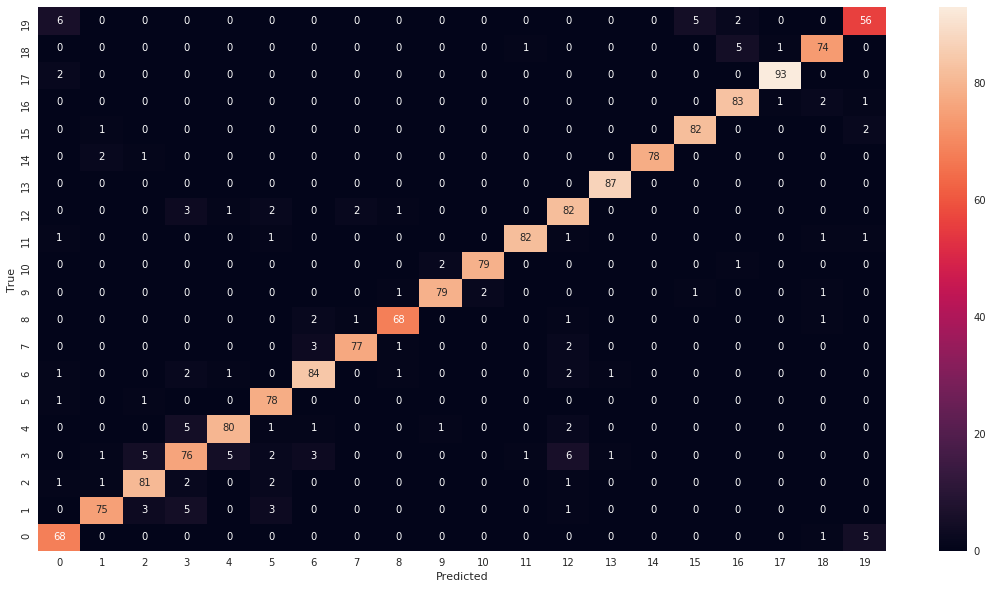

In [18]:
fig = print_results(np.reshape(y_true, (-1)), y_pred)
fig.savefig('{}/cm.png'.format(working_dir))